# Imports 

In [4]:
import os
import numpy as np

import torch
import torchvision
from torchvision import datasets
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [5]:
# define training and test data directories
data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

In [8]:
#Data Augmentation

# resnet152 Takes 224x224 images as input, so we resize all of them
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))]) #This normalization from ImageNET

valid_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])
test_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  2000
Num valid images:  150
Num test images:  600


In [10]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


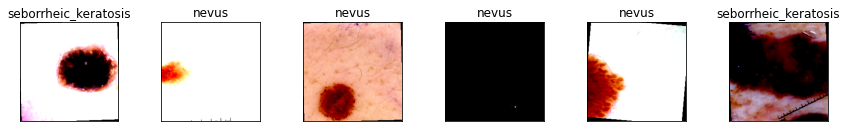

In [16]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [20]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        #convolutional layer (224x224x3)
        self.conv1 = nn.Conv2d(3 , 64 ,3 ,padding = 1)
        #convolutional layer (112x112x64)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        #convolutional layer (56x56x128)
        self.conv3 = nn.Conv2d(128,256,3,padding=1)
        #convolutional layer (28x28x256)
        self.conv4 = nn.Conv2d(256,512,3,padding=1)
        #max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        #linear layer (512 * 14 * 14 ->1024)
        self.fc1 = nn.Linear(512 *14 * 14 ,1024)
        #linear layer (1024 - > 133)
        self.fc2 = nn.Linear(1024,3)
        #drop out
        self.dropout = nn.Dropout(0.20)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model_scratch.cuda()
    
print(model_scratch)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
import torch.optim as optim

In [22]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.01)

In [23]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #first we clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #backward pass : loss of gradient computation
            loss.backward()
            #update parameters by aingle step optimization
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            valid_loss += loss.item()*data.size(0)
        ## update the average validation loss
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss  <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

loaders_scratch = {'train' : train_loader,
                  'valid' : valid_loader,
                  'test' : test_loader
                    }

# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, train_on_gpu, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 17.645259 	Validation Loss: 1.093355
Validation loss decreased (inf --> 1.093355).  Saving model ...
Epoch: 2 	Training Loss: 0.838323 	Validation Loss: 1.165322
Epoch: 3 	Training Loss: 0.842822 	Validation Loss: 1.091962
Validation loss decreased (1.093355 --> 1.091962).  Saving model ...
Epoch: 4 	Training Loss: 0.838095 	Validation Loss: 1.114322
Epoch: 5 	Training Loss: 0.840147 	Validation Loss: 1.121272
Epoch: 6 	Training Loss: 0.840169 	Validation Loss: 1.071573
Validation loss decreased (1.091962 --> 1.071573).  Saving model ...
Epoch: 7 	Training Loss: 0.840234 	Validation Loss: 1.138545
Epoch: 8 	Training Loss: 0.843223 	Validation Loss: 1.167688
Epoch: 9 	Training Loss: 0.839419 	Validation Loss: 1.079779
Epoch: 10 	Training Loss: 0.838522 	Validation Loss: 1.059720
Validation loss decreased (1.071573 --> 1.059720).  Saving model ...
Epoch: 11 	Training Loss: 0.840681 	Validation Loss: 1.113417
Epoch: 12 	Training Loss: 0.837321 	Validation Loss: 1.

<All keys matched successfully>

In [24]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, train_on_gpu)

Test Loss: 0.882768


Test Accuracy: 65% (393/600)


# Transfer learning using ResNet152

In [25]:
# define ResNet152 model
ResNet152 = models.resnet152(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    ResNet152 = ResNet152.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/nobot/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [26]:
#loading the ResNet152 pretrained model from pytorch
model_transfer_1= ResNet152 
print(model_transfer_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
for param in model_transfer_1.parameters():
    param.requires_grad = False

In [32]:
n_inputs =model_transfer_1.fc.in_features
last_layer = nn.Linear(n_inputs,3)
model_transfer_1.fc = last_layer

if train_on_gpu:
    model_transfer_1 = model_transfer_1.cuda()
    
print (model_transfer_1.fc)

Linear(in_features=2048, out_features=3, bias=True)


In [35]:
params_to_update = model_transfer_1.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_transfer_1.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

criterion_transfer_1 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_transfer_1 = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.weight
	 fc.bias


In [37]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #first we clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #backward pass : loss of gradient computation
            loss.backward()
            #update parameters by aingle step optimization
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            valid_loss += loss.item()*data.size(0)
        ## update the average validation loss
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss  <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer_1.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

loaders_transfer = {'train' : train_loader,
                  'valid' : valid_loader,
                  'test' : test_loader
                    }



In [39]:
# train the model
model_transfer_1 =train(20, loaders_transfer, model_transfer_1, optimizer_transfer_1, criterion_transfer_1, train_on_gpu, 'model_transfer_1.pt')



Epoch: 1 	Training Loss: 0.800381 	Validation Loss: 1.183904
Validation loss decreased (inf --> 1.183904).  Saving model ...
Epoch: 2 	Training Loss: 0.757300 	Validation Loss: 0.974199
Validation loss decreased (1.183904 --> 0.974199).  Saving model ...
Epoch: 3 	Training Loss: 0.753864 	Validation Loss: 0.816629
Validation loss decreased (0.974199 --> 0.816629).  Saving model ...
Epoch: 4 	Training Loss: 0.690772 	Validation Loss: 0.788539
Validation loss decreased (0.816629 --> 0.788539).  Saving model ...
Epoch: 5 	Training Loss: 0.733234 	Validation Loss: 1.010782
Epoch: 6 	Training Loss: 0.682514 	Validation Loss: 0.792260
Epoch: 7 	Training Loss: 0.741828 	Validation Loss: 0.738541
Validation loss decreased (0.788539 --> 0.738541).  Saving model ...
Epoch: 8 	Training Loss: 0.694696 	Validation Loss: 0.999353
Epoch: 9 	Training Loss: 0.686612 	Validation Loss: 0.898366
Epoch: 10 	Training Loss: 0.688252 	Validation Loss: 1.025356
Epoch: 11 	Training Loss: 0.710756 	Validation Lo

In [40]:
# load the model that got the best validation accuracy
model_transfer_1.load_state_dict(torch.load('model_transfer_1.pt'))


<All keys matched successfully>

In [41]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
# call test function 
test(loaders_transfer, model_transfer_1, criterion_transfer_1, train_on_gpu)

Test Loss: 0.717117


Test Accuracy: 70% (425/600)


# transfer learning using Inception_V3

In [68]:
# inception_V3 Takes 299x299 images as input, so we resize all of them
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(0, 359),
    transforms.ToTensor(),
    transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))]) #This normalization from ImageNET

valid_transform = transforms.Compose([transforms.RandomResizedCrop(299), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])
test_transform = transforms.Compose([transforms.RandomResizedCrop(299), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  2000
Num valid images:  150
Num test images:  600


In [55]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [44]:
# define inception_v3 model
inception_v3 = models.inception_v3(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    inception_v3 = inception_v3.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/nobot/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [74]:
model_transfer_2= inception_v3
print(model_transfer_2)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [75]:
for param in model_transfer_2.parameters():
    param.requires_grad = False

In [76]:
# Handle the auxilary net
n_inputs_auxilary =model_transfer_2.AuxLogits.fc.in_features
fine_tuned_layer_1 = nn.Linear(n_inputs_auxilary,3)
model_transfer_2.AuxLogits.fc = fine_tuned_layer_1 

# Handle the primary net
n_inputs_primary =model_transfer_2.fc.in_features
fine_tuned_layer_2 = nn.Linear(n_inputs_primary,3)
model_transfer_2.fc = fine_tuned_layer_2

if train_on_gpu:
    model_transfer_2 = model_transfer_2.cuda()
    
    

print(n_inputs_auxilary)
print(n_inputs_primary)
print (model_transfer_2.AuxLogits.fc)
print (model_transfer_2.fc)

768
2048
Linear(in_features=768, out_features=3, bias=True)
Linear(in_features=2048, out_features=3, bias=True)


In [90]:
params_to_update = model_transfer_2.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_transfer_2.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

criterion_transfer_2 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_transfer_2 = optim.RMSprop(params_to_update,lr = 0.0001,eps=0.1,weight_decay=0.5,momentum=0.9)
# scheduler_transfer_2 = optim.lr_scheduler.StepLR(optimizer_transfer_2, step_size=3, gamma=0.2)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [91]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        
#         scheduler_transfer_2.step()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #first we clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass : pass input to model to get output
            output, aux_outputs = model(data)
            #calculating batch loss
            loss1 = criterion(output,target)
            loss2 = criterion(aux_outputs, target)
            loss = loss1 + 0.4*loss2
            #backward pass : loss of gradient computation
            loss.backward()
            #update parameters by aingle step optimization
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            valid_loss += loss.item()*data.size(0)
        ## update the average validation loss
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss  <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer_2.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

loaders_transfer = {'train' : train_loader,
                  'valid' : valid_loader,
                  'test' : test_loader
                    }



In [93]:
# train the model
model_transfer_2 =train(15, loaders_transfer, model_transfer_2, optimizer_transfer_2, criterion_transfer_2, train_on_gpu, 'model_transfer_2.pt')



Epoch: 1 	Training Loss: 2.556762 	Validation Loss: 1.621543
Validation loss decreased (inf --> 1.621543).  Saving model ...
Epoch: 2 	Training Loss: 2.029410 	Validation Loss: 1.376855
Validation loss decreased (1.621543 --> 1.376855).  Saving model ...
Epoch: 3 	Training Loss: 1.793002 	Validation Loss: 1.137433
Validation loss decreased (1.376855 --> 1.137433).  Saving model ...
Epoch: 4 	Training Loss: 1.547155 	Validation Loss: 1.128858
Validation loss decreased (1.137433 --> 1.128858).  Saving model ...
Epoch: 5 	Training Loss: 1.387760 	Validation Loss: 1.103453
Validation loss decreased (1.128858 --> 1.103453).  Saving model ...
Epoch: 6 	Training Loss: 1.200794 	Validation Loss: 0.989224
Validation loss decreased (1.103453 --> 0.989224).  Saving model ...
Epoch: 7 	Training Loss: 1.131919 	Validation Loss: 0.885379
Validation loss decreased (0.989224 --> 0.885379).  Saving model ...
Epoch: 8 	Training Loss: 1.078311 	Validation Loss: 1.000301
Epoch: 9 	Training Loss: 1.049051 

In [94]:
# load the model that got the best validation accuracy
model_transfer_2.load_state_dict(torch.load('model_transfer_2.pt'))

<All keys matched successfully>

In [95]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #calculating batch loss
        loss = criterion(output,target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
# call test function 
test(loaders_transfer, model_transfer_2, criterion_transfer_2, train_on_gpu)

Test Loss: 0.755916


Test Accuracy: 69% (417/600)


# Trying to train after balancing the dataset



One of my mistakes in the up code which i have realized now is that i have imbalanced data.
I will use this class **imbalanced dataset sampler** implemented by Ufoym team to balance the data.
https://github.com/ufoym/imbalanced-dataset-sampler


In [7]:
# this function is used to check the imbalanced data in our dataset
def parse_folder(folder_to_parse):
    melanoma_count = 0
    nevus_count = 0
    seborrheic_keratosis_count = 0

    folders_path = Path(folder_to_parse)
    for directory in folders_path.iterdir():
        if directory.is_dir():
            for deep_directory in directory.iterdir():
                if deep_directory.is_dir():
                    for file in deep_directory.iterdir():
                        if file.is_file() and deep_directory.name == 'melanoma':
                            melanoma_count +=1
                        if file.is_file() and deep_directory.name == 'nevus':
                            nevus_count += 1
                        if file.is_file() and deep_directory.name == 'seborrheic_keratosis':
                            seborrheic_keratosis_count += 1

    print('total number of melanoma samples = ' + str(melanoma_count))
    print('total number of nevus samples = ' + str(nevus_count))
    print('total number of seborrheic_keratosis samples = ' + str(seborrheic_keratosis_count))

parse_folder(data_dir)

total number of melanoma samples = 521
total number of nevus samples = 1843
total number of seborrheic_keratosis samples = 386


As we can see nevus images has more samples than melanoma and seborrheic_keratosis.

In [8]:
#This class(imbalanced dataset sampler) implemented by Ufoym team
# https://github.com/ufoym/imbalanced-dataset-sampler


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [29]:
#Data Augmentation

# resnet152 Takes 224x224 images as input, so we resize all of them
train_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))]) #This normalization from ImageNET

valid_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])
test_transform = transforms.Compose([transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485 , 0.456 ,0.406),(0.229 , 0.224 , 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)


# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders


train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=ImbalancedDatasetSampler(train_data),
                                          num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,sampler=ImbalancedDatasetSampler(valid_data),
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,sampler=ImbalancedDatasetSampler(test_data),
                                          num_workers=num_workers)

# Transfer learning using ResNet152 with balanced data

In [27]:
# define ResNet152 model
ResNet152 = models.resnet152(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    ResNet152 = ResNet152.cuda()

In [30]:
#loading the ResNet152 pretrained model from pytorch
model_transfer_3= ResNet152 
print(model_transfer_3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
for param in model_transfer_3.parameters():
    param.requires_grad = False

In [32]:
n_inputs =model_transfer_3.fc.in_features
last_layer = nn.Linear(n_inputs,3)
model_transfer_3.fc = last_layer

if train_on_gpu:
    model_transfer_3 = model_transfer_3.cuda()
    
print (model_transfer_3.fc)

Linear(in_features=2048, out_features=3, bias=True)


In [33]:
params_to_update = model_transfer_3.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_transfer_3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

criterion_transfer_3 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_transfer_3 = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.weight
	 fc.bias


In [34]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #first we clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #backward pass : loss of gradient computation
            loss.backward()
            #update parameters by aingle step optimization
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            
            #forward pass : pass input to model to get output
            output = model(data)
            #calculating batch loss
            loss = criterion(output,target)
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            valid_loss += loss.item()*data.size(0)
        ## update the average validation loss
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss  <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer_3.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

loaders_transfer = {'train' : train_loader,
                  'valid' : valid_loader,
                  'test' : test_loader
                    }



In [35]:
# train the model
model_transfer_3 =train(20, loaders_transfer, model_transfer_3, optimizer_transfer_3, criterion_transfer_3, train_on_gpu, 'model_transfer_3.pt')



Epoch: 1 	Training Loss: 1.001754 	Validation Loss: 0.762207
Validation loss decreased (inf --> 0.762207).  Saving model ...
Epoch: 2 	Training Loss: 0.917463 	Validation Loss: 0.873379
Epoch: 3 	Training Loss: 0.891408 	Validation Loss: 0.757641
Validation loss decreased (0.762207 --> 0.757641).  Saving model ...
Epoch: 4 	Training Loss: 0.874580 	Validation Loss: 0.710157
Validation loss decreased (0.757641 --> 0.710157).  Saving model ...
Epoch: 5 	Training Loss: 0.836264 	Validation Loss: 0.776888
Epoch: 6 	Training Loss: 0.876131 	Validation Loss: 0.793070
Epoch: 7 	Training Loss: 0.822339 	Validation Loss: 0.757774
Epoch: 8 	Training Loss: 0.795826 	Validation Loss: 0.810662
Epoch: 9 	Training Loss: 0.781622 	Validation Loss: 0.745562
Epoch: 10 	Training Loss: 0.795154 	Validation Loss: 0.758364
Epoch: 11 	Training Loss: 0.792295 	Validation Loss: 0.822828
Epoch: 12 	Training Loss: 0.813188 	Validation Loss: 0.761408
Epoch: 13 	Training Loss: 0.811930 	Validation Loss: 0.757285
E

In [36]:
# load the model that got the best validation accuracy
model_transfer_3.load_state_dict(torch.load('model_transfer_3.pt'))

<All keys matched successfully>

In [37]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
# call test function 
test(loaders_transfer, model_transfer_3, criterion_transfer_3, train_on_gpu)

Test Loss: 0.937307


Test Accuracy: 54% (327/600)
